In [137]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
from pathlib import Path
import pandas as pd
from scipy import stats
from tqdm import tqdm

rng = np.random.RandomState(42)
covid_datasets_dir = Path('covid-datasets')
print('Done!')

Done!


## Loading in and filtering Cohen data

In [41]:
cohen_covid_md = pd.read_csv(str(Path('covid-datasets/covid-chestxray-dataset/metadata.csv')))
print(f'Total Images: {cohen_covid_md.shape[0]}')
# Removes all non-covid data from dataframe
cohen_covid_md = cohen_covid_md[(cohen_covid_md['finding'] == 'COVID-19')]
print(f'Total COVID-19 Images: {cohen_covid_md.shape[0]}')
# Removes all non-X-Ray data from dataframe
cohen_covid_md = cohen_covid_md[(cohen_covid_md['modality'] == 'X-ray')]
print(f'Total COVID-19 X-Rays: {cohen_covid_md.shape[0]}')
# Drops all duplicated patient X-rays except for the first X-ray (earliest offset)
cohen_covid_md = cohen_covid_md.drop_duplicates('patientid', keep='first')
print(f'Total Unique Patient COVID-19 X-Rays: {cohen_covid_md.shape[0]}')
# Removes all Lateral X-rays (keeps only PA or AP images)
cohen_covid_md = cohen_covid_md[cohen_covid_md['view'].isin(['PA', 'AP', 'AP Supine'])]
print(f'Total Unique Patient COVID-19 PA, AP, or AP Supine X-Rays: {cohen_covid_md.shape[0]}')

Total Images: 673
Total COVID-19 Images: 526
Total COVID-19 X-Rays: 446
Total Unique Patient COVID-19 X-Rays: 259
Total Unique Patient COVID-19 PA, AP, or AP Supine X-Rays: 259


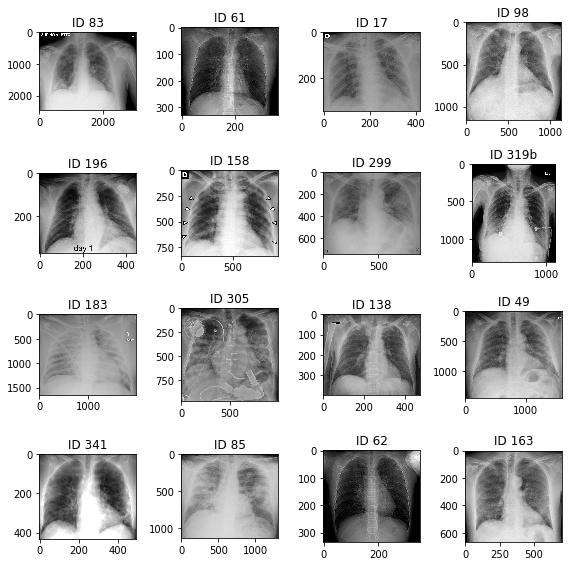

In [4]:
cohen_image_dir = covid_datasets_dir / 'covid-chestxray-dataset' / 'images'
# gets a list of all .png and .jpg images in cohen dataset
# cohen_image_paths = sorted(list(cohen_image_paths.glob('**/*.png')) + list(cohen_image_paths.glob('**/*.jpg')))
sqrt_n_samples = 4
fig, axes = plt.subplots(nrows=sqrt_n_samples, ncols=sqrt_n_samples, figsize=(8,8))
xray_samples = cohen_covid_md.sample(n=sqrt_n_samples**2, random_state=rng, axis=0)
for ax, xray_sample in zip(axes.ravel(), xray_samples.iterrows()):
    xray_sample = xray_sample[1]
    image = plt.imread(str(cohen_image_dir / xray_sample['filename']))
    ax.imshow(image, cmap='gray')
    ax.set_title(f"ID {xray_sample['patientid']}")
plt.tight_layout()
plt.show()

# Metadata analysis

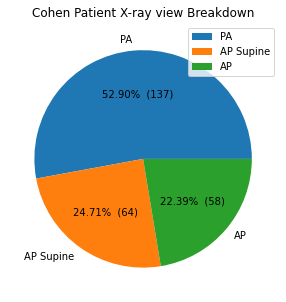

In [50]:
# Getting view distribution
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


views = cohen_covid_md['view']
views = pd.Series([i.split(',')[-1] if i is not np.nan else 'Unknown' for i in views])
views = views.value_counts(dropna=False)

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(views, labels=views.index, autopct=make_autopct(views))
ax.legend(loc='best')
ax.set_title('Cohen Patient X-ray view Breakdown')
plt.savefig('cohen-patient-views')
plt.show()

In [90]:
test[0]

'000001-12.jpg'

Age mean (ignoring nan): 58.7297 
Age std (ignoring nan):  16.2684


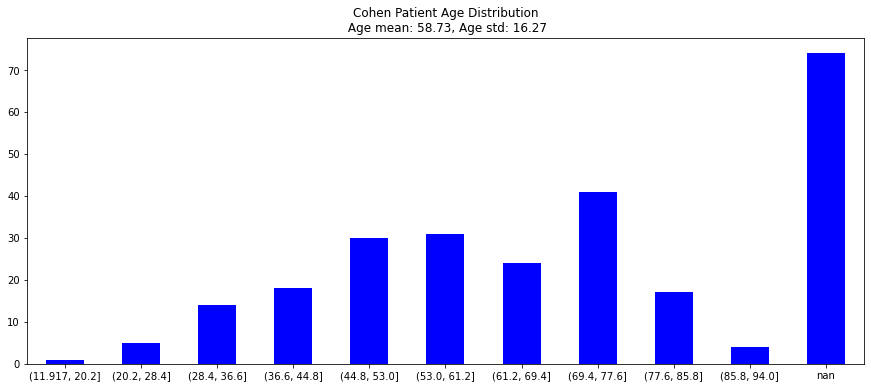

In [17]:
# Getting age distribution
age_bins = pd.cut(cohen_covid_md['age'], bins=10, include_lowest=True)
age_mean = np.nanmean(cohen_covid_md["age"].to_numpy())
age_std = np.nanstd(cohen_covid_md["age"].to_numpy())
print(f'Age mean (ignoring nan): {age_mean:.4f} \n' + 
      f'Age std (ignoring nan):  {age_std:.4f}')
title = f'Cohen Patient Age Distribution\n Age mean: {age_mean:.2f}, Age std: {age_std:.2f}'
age_bins.value_counts(sort=False, dropna=False).plot.bar(x='Age', y='Count',
                                                         rot=0, color="b", figsize=(15,6),
                                                         title= title)
plt.savefig('cohen-age-distribution')

All countries: Index(['Italy', ' Germany', ' Italy', 'Unknown', ' China', ' USA', 'Hong Kong',
       ' United Kingdom ', ' Spain', ' Iran', 'China', ' United Kingdom',
       'Spain', 'South Korea', 'Taiwan', 'Singapore', ' Taiwan', ' Japan',
       'United Kingdom ', ' Vietnam', 'United Kingdom', ' Philippines',
       ' Italy ', ' South Korea', ' Canada', 'Belgium', 'Turkey', ' Australia',
       ' Portugal', 'Thailand', ' Greece', ' Taiwan ', ' Israel', ' Belgium',
       ' Austria', ' Sweden', ' Colombia', ' Pakistan', ' Turkey', ' Spain ',
       'Australia', 'Pakistan'],
      dtype='object')


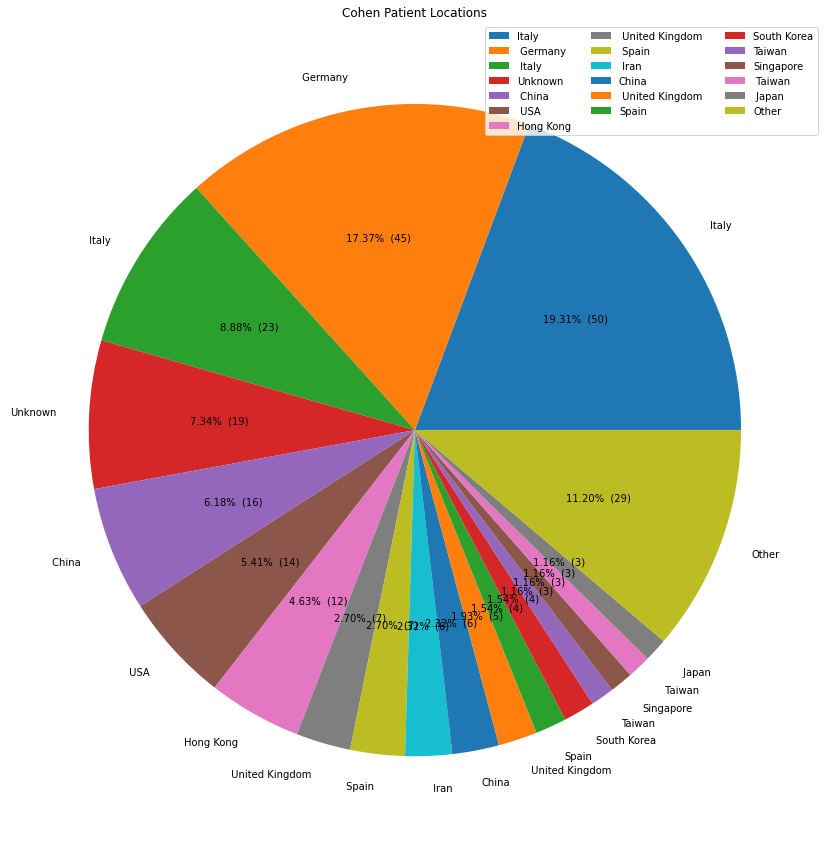

In [57]:
# Getting Location distribution
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


locations = cohen_covid_md['location'].copy()
# cohen_covid_md["location"].value_counts(dropna=False).plot(kind='pie', legend=True
countries = pd.Series([i.split(',')[-1] if i is not np.nan else 'Unknown' for i in locations])
countries = countries.value_counts(dropna=False)

print(f'All countries: {countries.index}')
other = 0 
for country in countries.iteritems():
    if country[1] < 3:
        other += country[1]
        countries.drop(country[0], inplace=True)
countries = countries.append(pd.Series({'Other': other}))
fig, ax = plt.subplots(figsize=(15, 15))
ax.pie(countries, labels=countries.index, autopct=make_autopct(countries))
ax.legend(loc='upper right', ncol=3)
ax.set_title('Cohen Patient Locations')
plt.savefig('cohen-patient-locations')
plt.show()

In [20]:
stats.describe(cohen_covid_md['offset'], nan_policy='omit')

DescribeResult(nobs=201, minmax=(masked_array(data=-12.,
             mask=False,
       fill_value=1e+20), masked_array(data=28.,
             mask=False,
       fill_value=1e+20)), mean=4.149253731343284, variance=42.9176119402985, skewness=masked_array(data=1.15506772,
             mask=False,
       fill_value=1e+20), kurtosis=3.069891672387894)

offset mean (ignoring nan): 5.0547 
offset std (ignoring nan):  5.8626


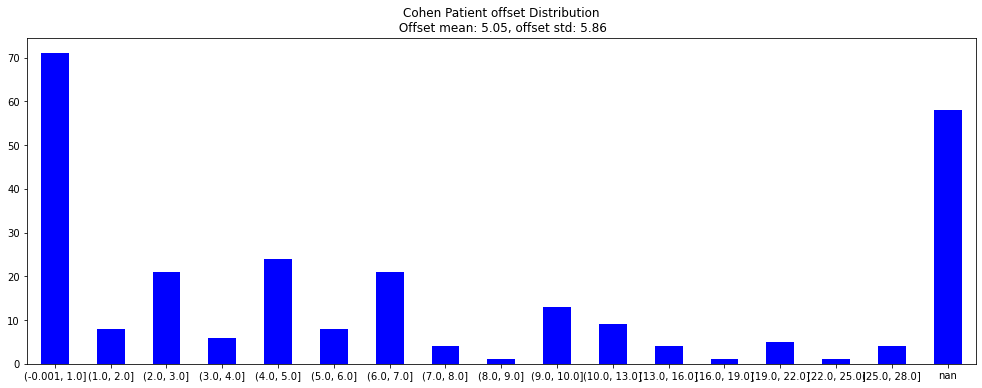

In [41]:
# Getting offset distribution
cohen_covid_md['offset'] = abs(cohen_covid_md['offset'])
bins = np.arange(0,11)
bins = np.concatenate((bins, np.arange(13, 30, step=3)))
offset_bins = pd.cut(cohen_covid_md['offset'], bins=bins, include_lowest=True)
offset_mean = np.nanmean(cohen_covid_md["offset"].to_numpy())
offset_std = np.nanstd(cohen_covid_md["offset"].to_numpy())
print(f'offset mean (ignoring nan): {offset_mean:.4f} \n' + 
      f'offset std (ignoring nan):  {offset_std:.4f}')
title = f'Cohen Patient offset Distribution\n Offset mean: {offset_mean:.2f}, offset std: {offset_std:.2f}'
offset_bins.value_counts(sort=False, dropna=False).plot.bar(x='offset', y='Count',
                                                         rot=0, color="b", figsize=(17,6),
                                                         title= title)
plt.savefig('cohen-offset-distribution')

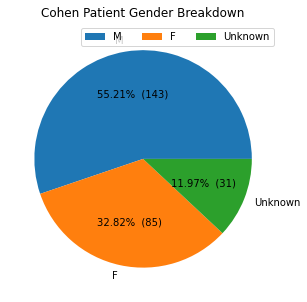

In [46]:
# Getting sex distribution
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


sexs = cohen_covid_md['sex']
sexs = pd.Series([i.split(',')[-1] if i is not np.nan else 'Unknown' for i in sexs])
sexs = sexs.value_counts(dropna=False)

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(sexs, labels=sexs.index, autopct=make_autopct(sexs))
ax.legend(loc='upper right', ncol=3)
ax.set_title('Cohen Patient Gender Breakdown')
plt.savefig('cohen-patient-sexs')
plt.show()

In [85]:
type(covid_set.pop())

str


# Loading in and filtering Figure 1 Covid Data

In [139]:
fig_covid_md= pd.read_csv(str(covid_datasets_dir / 'Figure1-COVID-chestxray-dataset'/ 'metadata.csv'), encoding= 'unicode_escape', index_col='patientid')
# Removes all non-covid and non-X-Ray data from dataframe
fig_covid_md  = fig_covid_md[(fig_covid_md['finding'] == 'COVID-19')]
print(f'Total COVID-19 Images: {fig_covid_md.shape[0]}')

fig_covid_md  = fig_covid_md[fig_covid_md['modality'] == 'X-ray']
print(f'Total COVID-19 X-ray images: {fig_covid_md.shape[0]}') 
# Getting unique patient ids
pat_ids = list(fig_covid_md.index.values)
unique_names = []
for name in pat_ids:
    split_name = name.split('-')[-1]
    if split_name.isdigit():
        repeated_flag = 0
        unique_names.append(name)
    else:  # if repeated it has an alpha value after the numeric id
        if repeated_flag == 0:
            unique_names.append(name)
            repeated_flag = 1
# # Drops all duplicated patient X-rays except for the first X-ray (earliest offset)
fig_covid_md  = fig_covid_md.loc[unique_names]
print(f'Total Unique Patient COVID-19 X-Rays: : {fig_covid_md.shape[0]}')
# Removes all Lateral X-rays (keeps only PA, AP, AP erect, or unlabeled images)
fig_covid_md = fig_covid_md[fig_covid_md['view'].isin(['PA', 'AP', 'AP erect', np.NaN])]
print(f'Total Unique Patient COVID-19 PA, AP, AP erect, or not-labeled X-Rays: {fig_covid_md.shape[0]}\n\
Note: ^This is including not labeled views, because otherwise there would only be 6 cases')



Total COVID-19 Images: 35
Total COVID-19 X-ray images: 35
Total Unique Patient COVID-19 X-Rays: : 30
Total Unique Patient COVID-19 PA, AP, AP erect, or not-labeled X-Rays: 30
Note: ^This is including not labeled views, because otherwise there would only be 6 cases


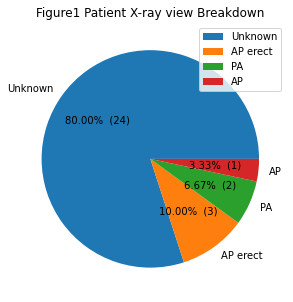

In [77]:
# Getting view distribution
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


views = fig_covid_md['view']
views = pd.Series([i.split(',')[-1] if i is not np.nan else 'Unknown' for i in views])
views = views.value_counts(dropna=False)

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(views, labels=views.index, autopct=make_autopct(views))
ax.legend(loc='best')
ax.set_title('Figure1 Patient X-ray view Breakdown')
plt.savefig('figure1-patient-views')
plt.show()

Age mean (ignoring nan): 50.7692 
Age std (ignoring nan):  13.7346


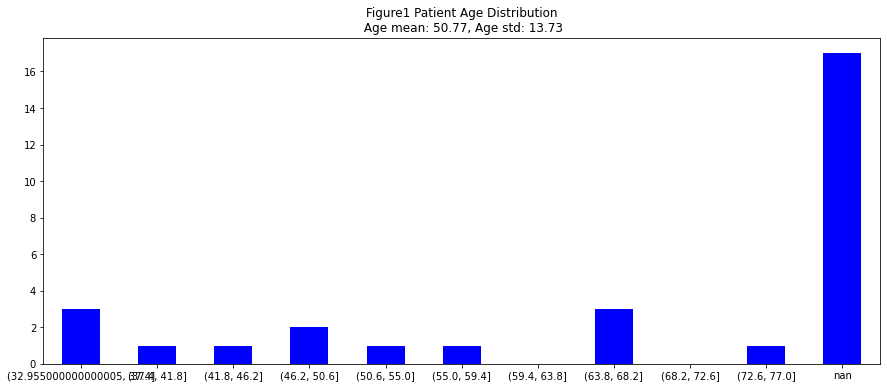

In [137]:
# Getting age distribution

# some ages have a +, this removes that
def get_rid_of_that_plus(string):
    string = str(string)
    val = string.split('+')[0]
    return(float(val))
fig_covid_md['age'] = fig_covid_md['age'].apply(get_rid_of_that_plus)
    
age_bins = pd.cut(fig_covid_md['age'], bins=10, include_lowest=True)
age_mean = np.nanmean(fig_covid_md["age"].to_numpy())
age_std = np.nanstd(fig_covid_md["age"].to_numpy())
print(f'Age mean (ignoring nan): {age_mean:.4f} \n' + 
      f'Age std (ignoring nan):  {age_std:.4f}')
title = f'Figure1 Patient Age Distribution\n Age mean: {age_mean:.2f}, Age std: {age_std:.2f}'
age_bins.value_counts(sort=False, dropna=False).plot.bar(x='Age', y='Count',
                                                         rot=0, color="b", figsize=(15,6),
                                                         title=title)
plt.savefig('figure1-age-distribution')

offset mean (ignoring nan): 11.1000 
offset std (ignoring nan):  5.7697


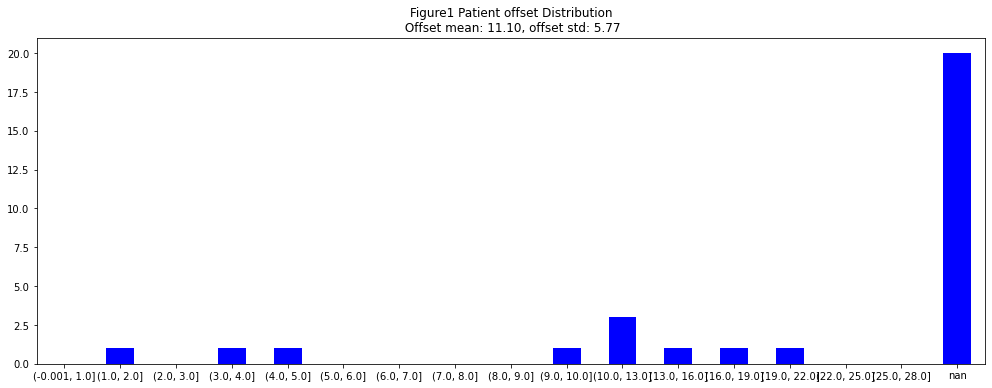

In [78]:
# Getting offset distribution
fig_covid_md['offset'] = abs(fig_covid_md['offset'])
bins = np.arange(0,11)
bins = np.concatenate((bins, np.arange(13, 30, step=3)))
offset_bins = pd.cut(fig_covid_md['offset'], bins=bins, include_lowest=True)
offset_mean = np.nanmean(fig_covid_md["offset"].to_numpy())
offset_std = np.nanstd(fig_covid_md["offset"].to_numpy())
print(f'offset mean (ignoring nan): {offset_mean:.4f} \n' + 
      f'offset std (ignoring nan):  {offset_std:.4f}')
title = f'Figure1 Patient offset Distribution\n Offset mean: {offset_mean:.2f}, offset std: {offset_std:.2f}'
offset_bins.value_counts(sort=False, dropna=False).plot.bar(x='offset', y='Count',
                                                         rot=0, color="b", figsize=(17,6),
                                                         title= title)
plt.savefig('figure1-offset-distribution')

In [58]:
len(list(model_images_dir.glob('*.*')))

272

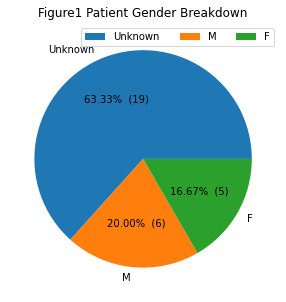

In [76]:
# Getting sex distribution
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


sexs = fig_covid_md['sex']
sexs = pd.Series([i.split(',')[-1] if i is not np.nan else 'Unknown' for i in sexs])
sexs = sexs.value_counts(dropna=False)

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(sexs, labels=sexs.index, autopct=make_autopct(sexs))
ax.legend(loc='upper right', ncol=3)
ax.set_title('Figure1 Patient Gender Breakdown')
plt.savefig('figure1-patient-sexs')
plt.show()

# RSNA

In [124]:
!dir RSNA-datasets

 Volume in drive C is SSD
 Volume Serial Number is 7CE5-496D

 Directory of C:\Users\SeanK\research\covid-sanity-checks\RSNA-datasets

06/23/2020  11:46 AM    <DIR>          .
06/23/2020  11:46 AM    <DIR>          ..
06/23/2020  11:30 AM                55 GCP Credits Request Link - RSNA.txt
06/23/2020  11:30 AM         1,647,396 stage_2_detailed_class_info.csv
06/23/2020  11:30 AM           159,027 stage_2_sample_submission.csv
06/23/2020  11:31 AM    <DIR>          stage_2_test_images
06/23/2020  11:38 AM    <DIR>          stage_2_train_images
06/23/2020  11:38 AM         1,490,034 stage_2_train_labels.csv
               4 File(s)      3,296,512 bytes
               4 Dir(s)  725,059,469,312 bytes free


In [110]:
import glob, pylab, pandas as pd
import pydicom, numpy as np

rsna_dir = Path('RSNA-datasets')

In [178]:
# building a metadata dataframe
# reading in csv metadata
df = pd.read_csv(str(rsna_dir / 'stage_2_train_labels.csv'), index_col='patientId')
df.drop(columns=['x', 'y', 'width', 'height'], inplace=True)
df = pd.concat((df, pd.read_csv(str(rsna_dir / 'stage_2_detailed_class_info.csv'), index_col='patientId')), axis=1)
df.head()

# getting more metadata frome dcim files
gender = []
view = []
age = []
patientId_list = []
for patientId in tqdm(df.index):
    dcm = pydicom.read_file(str(rsna_dir / 'stage_2_train_images' / patientId) + '.dcm')
    gender.append(dcm.PatientSex)
    view.append(dcm.ViewPosition)
    age.append(dcm.PatientAge)
    patientId_list.append(patientId)
    
# combining it all
frame = {
    'gender': gender,
    'view': view,
    'age': age   
}
more_meta_df = pd.DataFrame(frame, index=patientId_list)
more_meta_df.index.name = 'patientId_list'
df = pd.concat((df, more_meta_df), axis=1)
df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████| 30227/30227 [00:27<00:00, 1109.08it/s]


,Target,class,gender,view,age
0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,No Lung Opacity / Not Normal,F,PA,51
00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,No Lung Opacity / Not Normal,F,PA,48
00322d4d-1c29-4943-afc9-b6754be640eb,0,No Lung Opacity / Not Normal,M,AP,19
003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,Normal,M,PA,28
00436515-870c-4b36-a041-de91049b9ab4,1,Lung Opacity,F,AP,32


In [174]:
normal = df[df['class'].isin(['Normal'])]
other = df[df['class'].isin(['No Lung Opacity / Not Normal'])]
lung_opacity = df[df['class'].isin(['Lung Opacity'])]
normal_samples = normal.sample(n=300, random_state=rng)
other_samples = other.sample(n=300, random_state=rng)
lung_opacity_samples = lung_opacity.sample(n=300, random_state=rng)